In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.models import Model

Load Rtings and Movies CSV files

In [2]:
ratings_url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
ratings_columns = ['userId', 'movieId', 'rating', 'timestamp']
ratings_df = pd.read_csv(ratings_url, sep='\t', names=ratings_columns)

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies_url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.item"
movies_columns = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']
movies_df = pd.read_csv(movies_url, sep='|', names=movies_columns, encoding='latin-1')

In [6]:
movies_df.head()

,movieId,title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Create a user-movie matrix for collaborative filtering


In [9]:
user_movie_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_movie_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Visualization

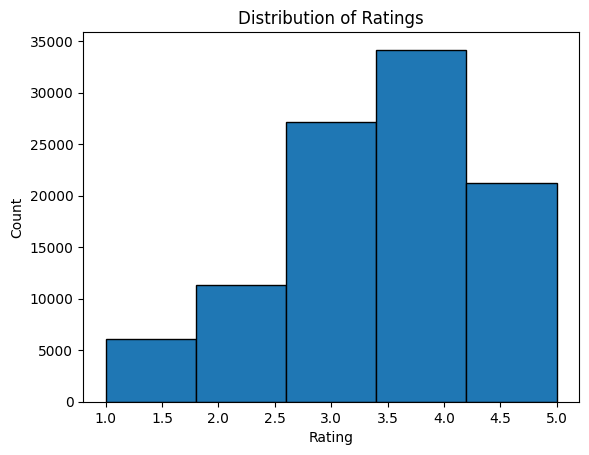

In [12]:
plt.hist(ratings_df['rating'], bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

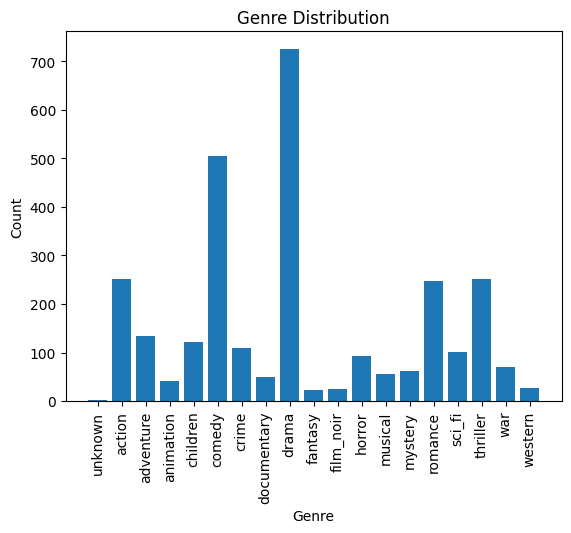

In [13]:
genre_counts = movies_df.iloc[:, 5:].sum()
plt.bar(genre_counts.index, genre_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution')
plt.show()


Split data into training and test sets


In [14]:
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)


Neural network model for collaborative filtering


In [15]:
num_users = user_movie_matrix.shape[0]
num_movies = user_movie_matrix.shape[1]

In [16]:
num_users

943

In [17]:
num_movies

1682

Map user and movie IDs to model indices


In [19]:
user_id_mapping = {id: idx for idx, id in enumerate(user_movie_matrix.index)}
movie_id_mapping = {id: idx for idx, id in enumerate(user_movie_matrix.columns)}

In [20]:
train_user_indices = train_data['userId'].map(user_id_mapping).values
train_movie_indices = train_data['movieId'].map(movie_id_mapping).values

In [21]:
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))


In [22]:
user_embedding = Embedding(input_dim=num_users, output_dim=10)(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=10)(movie_input)

In [23]:
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

In [24]:

concatenated = Concatenate()([user_vec, movie_vec])
dense_layer = Dense(128, activation='relu')(concatenated)
output_layer = Dense(1)(dense_layer)

In [25]:
model = Model(inputs=[user_input, movie_input], outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

Train the neural network model


In [26]:
model.fit([train_user_indices, train_movie_indices], train_data['rating'], epochs=5, verbose=1)


Epoch 1/5
2500/2500 [==============================] - 7s 2ms/step - loss: 1.2916
Epoch 2/5
2500/2500 [==============================] - 5s 2ms/step - loss: 0.8911
Epoch 3/5
2500/2500 [==============================] - 6s 2ms/step - loss: 0.8660
Epoch 4/5
2500/2500 [==============================] - 6s 2ms/step - loss: 0.8432
Epoch 5/5
2500/2500 [==============================] - 5s 2ms/step - loss: 0.8257


Recommend movies for a specific user using neural network


In [27]:
user_id = 1  # Choose a user
user_index = user_id_mapping[user_id]
user_indices = np.full(num_movies, user_index)
movie_indices = np.arange(num_movies)
predicted_ratings = model.predict([user_indices, movie_indices])
recommended_movie_indices = np.argsort(predicted_ratings.flatten())[::-1]

53/53 [==============================] - 0s 1ms/step


Filter out movies already rated by the user


In [28]:
user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']
recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_indices) & ~movies_df['movieId'].isin(user_rated_movies)]['title']
print(recommended_movies)

272                      Heat (1995)
273                   Sabrina (1995)
274     Sense and Sensibility (1995)
275         Leaving Las Vegas (1995)
276               Restoration (1995)
                    ...             
1676            Sweet Nothing (1995)
1677               Mat' i syn (1997)
1678                B. Monkey (1998)
1679            Sliding Doors (1998)
1680             You So Crazy (1994)
Name: title, Length: 1409, dtype: object
